# Criteria to select genes and cells

- eliminate proliferating cell types (not interested in proliferating cell states)
- remake the gene lists based on the DE new criteria (wilcox, pval threshold, sorted by logfc)

In [1]:
import os,sys
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.sparse
import anndata
import seaborn as sns
#import scvelo as scv

#import milopy.core as milo
#import milopy.plot as milopl


In [2]:
sc.set_figure_params(dpi=50, dpi_save=600) # Makes it more visible

In [4]:
tmpfile = '../h5ad_files/MegaK_Ery_lineage_wilcox_tmp.h5ad'

In [4]:
adata = sc.read_h5ad('h5ad_files/PAN.A01.v01.raw_count.20210429.MEM_PROGENITORS.embedding.h5ad')
adata

AnnData object with n_obs × n_vars = 149239 × 33538
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation'
    var: 'GeneID', 'GeneName', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'scvi_model_var'
    uns: 'leiden', 'scvi', 'umap'
    obsm: 'X_scvi', 'X_umap'
    obsp: 'scvi_connectivities', 'scvi_distances'

In [5]:
adata.raw

In [6]:
adata

AnnData object with n_obs × n_vars = 149239 × 33538
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation'
    var: 'GeneID', 'GeneName', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'scvi_model_var'
    uns: 'leiden', 'scvi', 'umap'
    obsm: 'X_scvi', 'X_umap'
    obsp: 'scvi_connectivities', 'scvi_distances'

In [7]:
adata.obs["anno_lvl_2_final_clean"].cat.categories

Index(['CMP', 'CYCLING_MEMP', 'CYCLING_MPP', 'CYCLING_YS_ERY', 'DN(P)_T',
       'DN(early)_T', 'DOUBLETS_FIBRO_ERY', 'DOUBLET_ERY_B',
       'DOUBLET_VSMC_ERYTHROCYTE', 'EARLY_ERY', 'EARLY_MK', 'GMP', 'HSC_MPP',
       'LATE_ERY', 'LATE_MK', 'LMPP_MLP', 'LOW_QUALITY_MID_ERY_(HIGH_RIBO)',
       'MACROPHAGE_ERY', 'MEMP', 'MEP', 'MID_ERY', 'PLACENTAL_CONTAMINANTS',
       'PRE_PRO_B', 'PROMONOCYTE', 'PROMYELOCYTE', 'VSMC_PERICYTE_III',
       'YS_ERY', 'nan'],
      dtype='object')

In [8]:
MegaK_Ery = adata[adata.obs['anno_lvl_2_final_clean'].isin(['MEMP', 'MEP', # added to wilcox version
                                                            'EARLY_ERY',
                                                            'MID_ERY',
                                                            'LATE_ERY',
                                                            'YS_ERY',
                                                            #'CYCLING_YS_ERY',
                                                            'EARLY_MK',
                                                            'LATE_MK',
                                                            'VSMC_PERICYTE_III',
                                                            'MACROPHAGE_ERY'])]
#del(adata)

In [9]:
MegaK_Ery.obs['anno_lvl_2_final_clean'] = MegaK_Ery.obs['anno_lvl_2_final_clean'].cat.reorder_categories(['MEMP', 'MEP',
                                                            'EARLY_ERY',
                                                            'MID_ERY',
                                                            'LATE_ERY',
                                                            'YS_ERY',
                                                            #'CYCLING_YS_ERY',
                                                            'EARLY_MK',
                                                            'LATE_MK',
                                                            'VSMC_PERICYTE_III',
                                                            'MACROPHAGE_ERY'])



/home/irepan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  # Remove the CWD from sys.path while we load stuff.


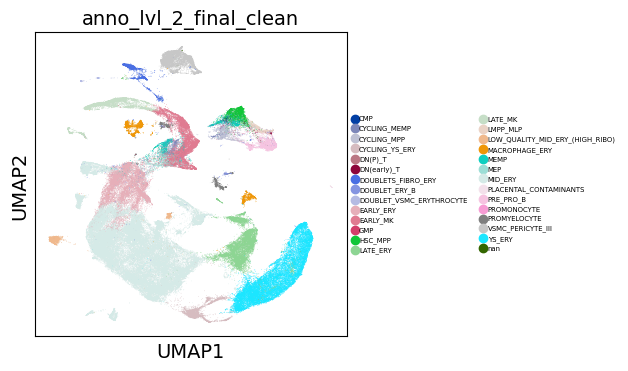

In [10]:
sc.pl.umap(adata, color="anno_lvl_2_final_clean",legend_fontsize= 5  )

In [11]:
sc.pp.normalize_per_cell(MegaK_Ery, counts_per_cell_after=10e4)
sc.pp.log1p(MegaK_Ery)

In [12]:
#pip install --user scikit-misc
#sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor= "seurat_v3" )min_mean :
sc.settings.verbosity = 4
sc.pp.highly_variable_genes(MegaK_Ery, min_mean=0.3, max_mean=5)

extracting highly variable genes
    Gene indices [6240] fell into a single bin: their normalized dispersion was set to 1.
    Decreasing `n_bins` will likely avoid this effect.
    finished (0:00:21)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


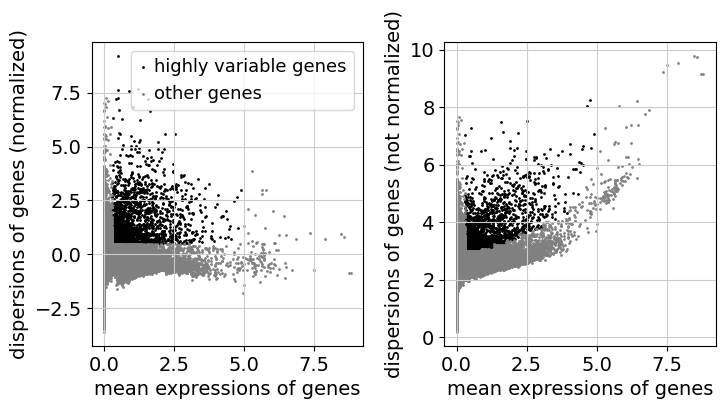

In [13]:
sc.pl.highly_variable_genes(MegaK_Ery)

normalizing counts per cell
    finished (0:00:01)


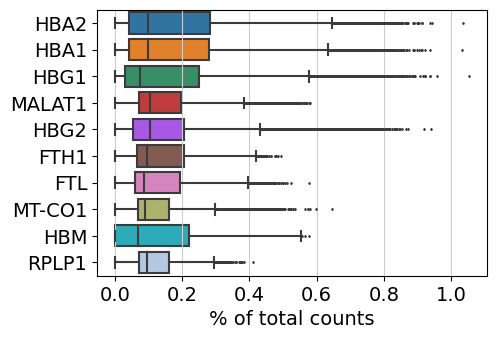

In [14]:
sc.pl.highest_expr_genes(MegaK_Ery, n_top=10, show=True)

### Perform comparison between t-test and wilcox data

ranking genes
    consider 'anno_lvl_2_final_clean' groups:
    with sizes: [ 2174  1407 11897 55104 10814 20370 10145  5472  6495  3302]
    finished: added to `.uns['t-test']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:19)


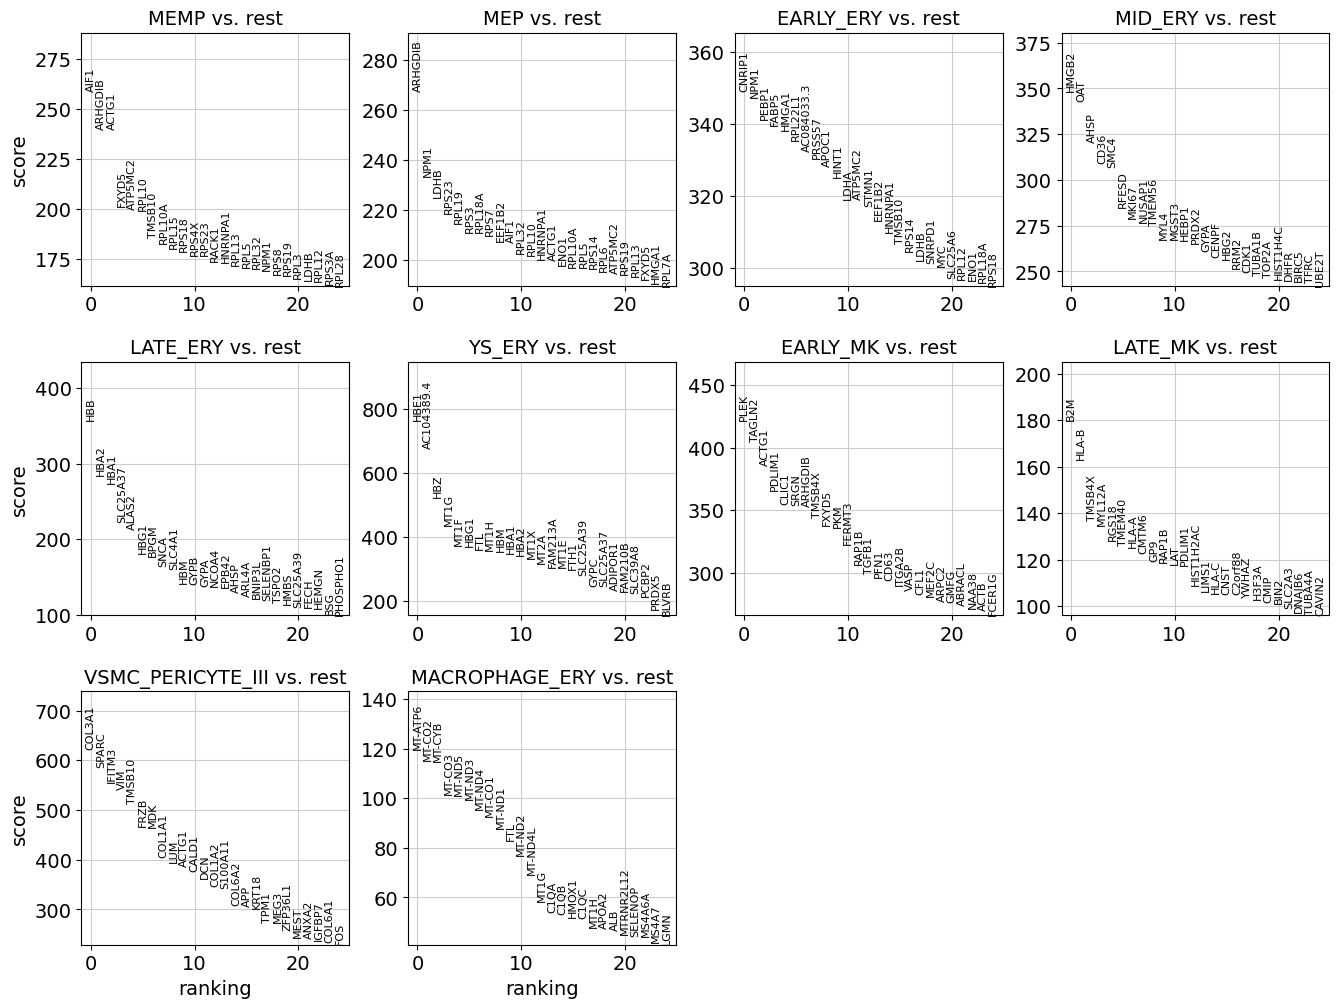

In [15]:
sc.tl.rank_genes_groups(MegaK_Ery, groupby= 'anno_lvl_2_final_clean', method='t-test', key_added= "t-test")
sc.pl.rank_genes_groups(MegaK_Ery,  n_genes=25,  sharey=False, key= "t-test")

ranking genes
    consider 'anno_lvl_2_final_clean' groups:
    with sizes: [ 2174  1407 11897 55104 10814 20370 10145  5472  6495  3302]
    finished: added to `.uns['wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:05:18)


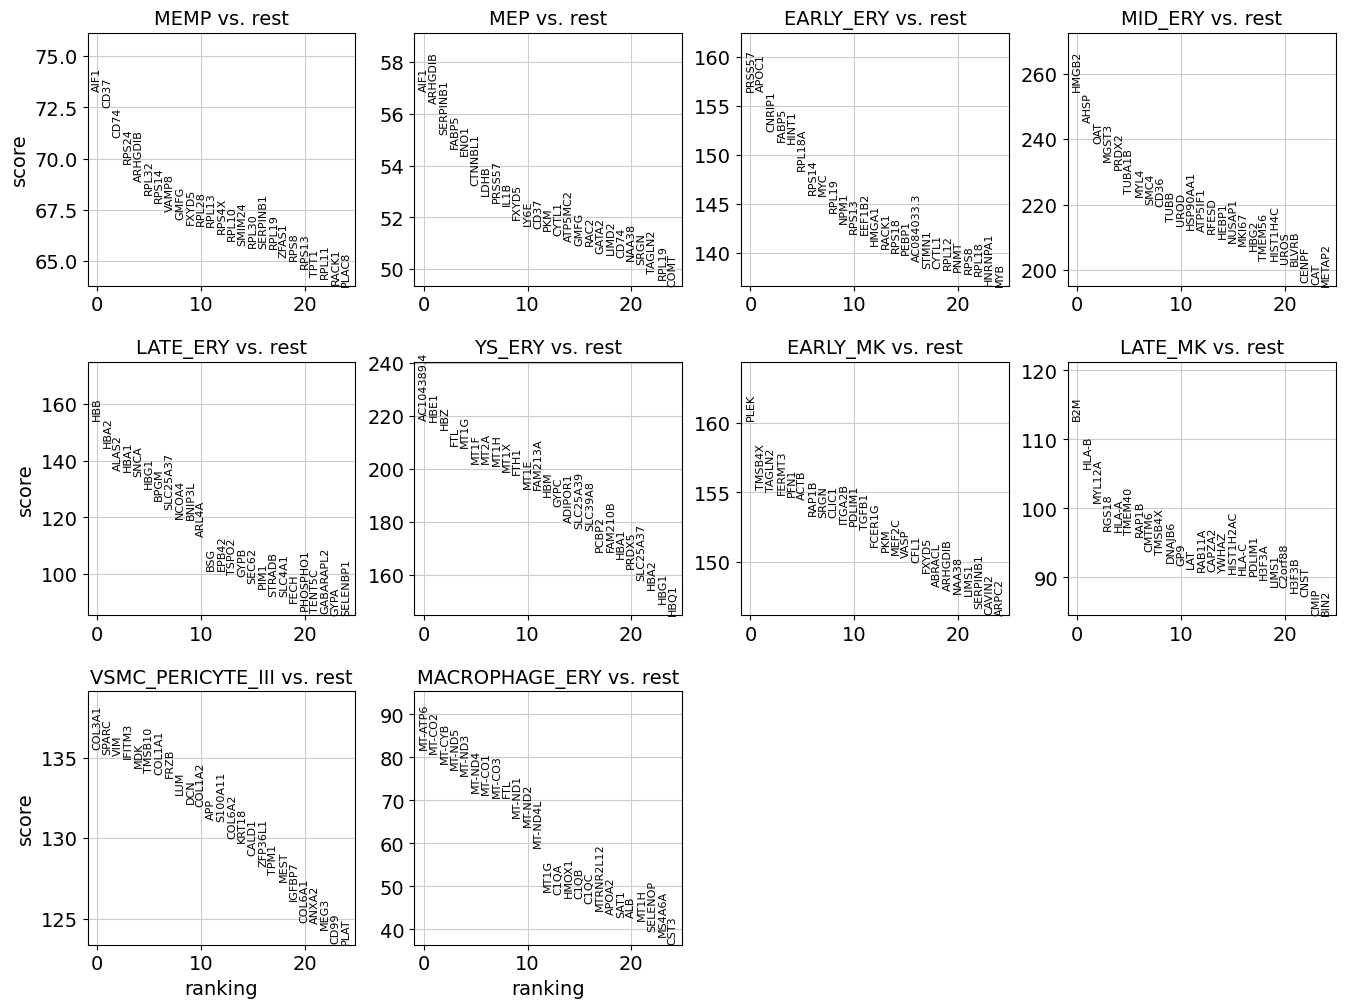

In [16]:
sc.tl.rank_genes_groups(MegaK_Ery, groupby= 'anno_lvl_2_final_clean', method='wilcoxon', key_added= "wilcoxon")
sc.pl.rank_genes_groups(MegaK_Ery,  n_genes=25,  sharey=False, key= "wilcoxon")

In [17]:
MegaK_Ery.write(tmpfile)

## Read preprocessed data

In [5]:
adata = sc.read_h5ad(tmpfile)

In [6]:
for clust in adata.obs.anno_lvl_2_final_clean.cat.categories: 
    f = "./DE_genelists_log2FC/MegaK_Ery/" + clust + ".csv"
    df = sc.get.rank_genes_groups_df(adata, group=clust,
                                    key='wilcoxon')
    df.to_csv(f, sep=",")

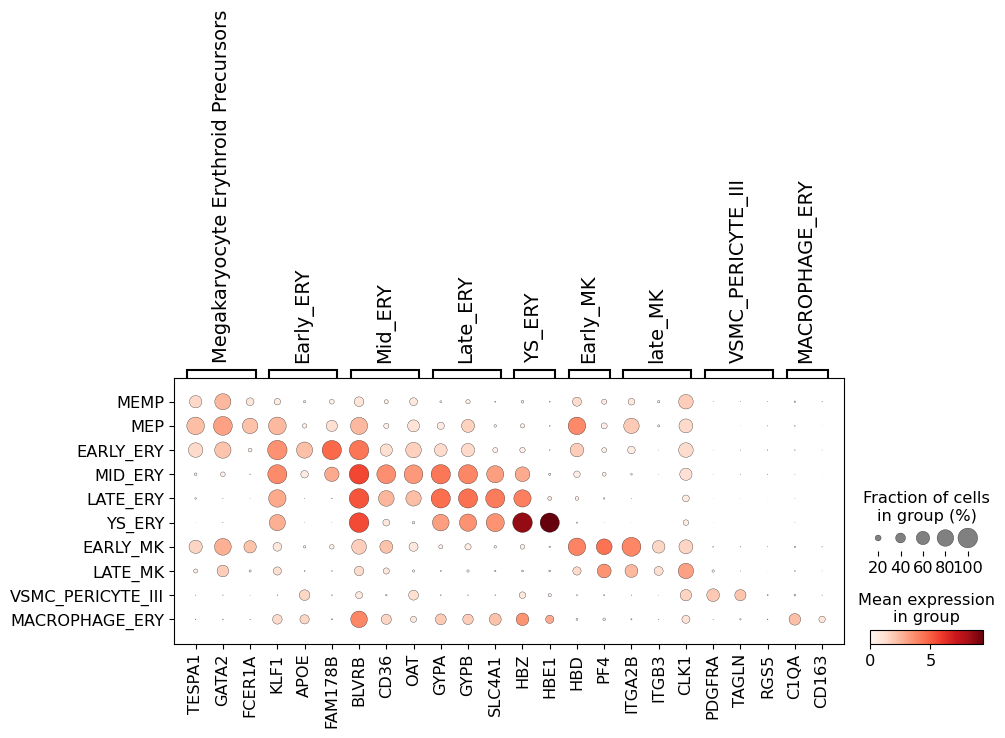

In [5]:
markers = {"Megakaryocyte Erythroid Precursors":['TESPA1','GATA2','FCER1A'],
"Early_ERY":['KLF1','APOE','FAM178B'],
"Mid_ERY":[ 'BLVRB', 'CD36', 'OAT',],
"Late_ERY":[ 'GYPA', 'GYPB', 'SLC4A1'],
"YS_ERY" : ['HBZ','HBE1'],
"Early_MK":['HBD','PF4'],
"late_MK":['ITGA2B','ITGB3','CLK1'],
"VSMC_PERICYTE_III":['PDGFRA', 'TAGLN','RGS5'],
'MACROPHAGE_ERY':["C1QA","CD163"]#,
#"Proliferating" : ["TOP2A","MKI67"],
          }
sc.pl.dotplot(adata, markers, 'anno_lvl_2_final_clean', dendrogram=False, use_raw=False, save='mega_anno.pdf')

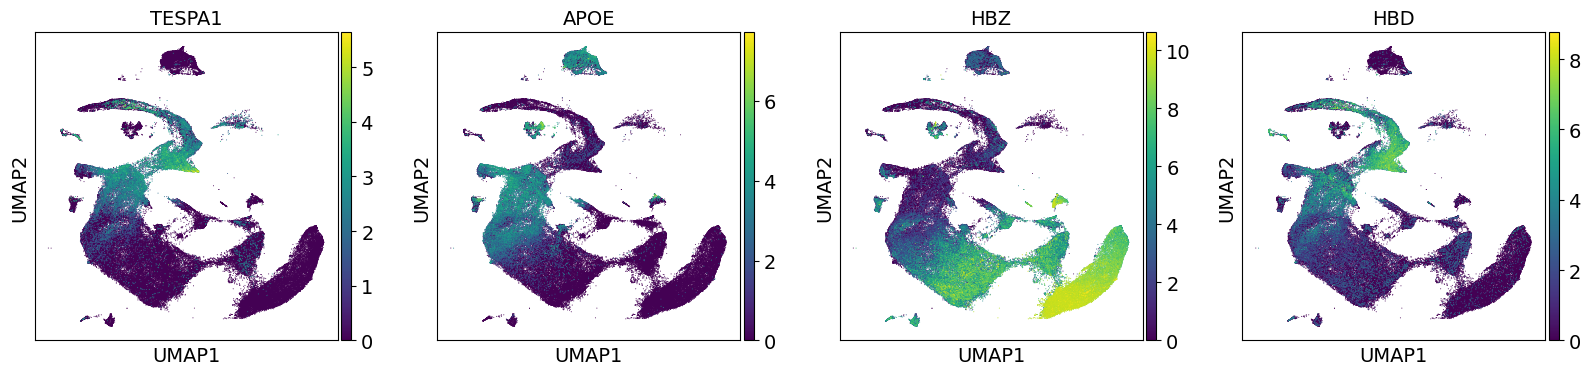

In [6]:
sc.pl.umap(adata, color= ["TESPA1", "APOE","HBZ" ,"HBD"], size=2 ) # top

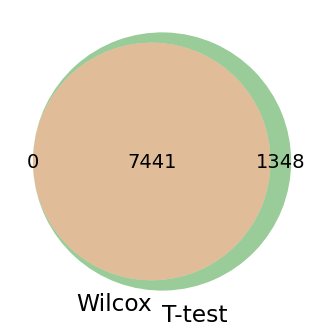

In [7]:
#compare EARLY_ERY genes
from matplotlib_venn import venn2

wc = sc.get.rank_genes_groups_df(adata, group='EARLY_ERY', key='wilcoxon', pval_cutoff=0.0001, log2fc_min=1)
tt = sc.get.rank_genes_groups_df(adata, group='EARLY_ERY', key='t-test', pval_cutoff=0.0001, log2fc_min=1)

venn2([set(wc['names']),set(tt['names'])], ('Wilcox','T-test') )
plt.show()

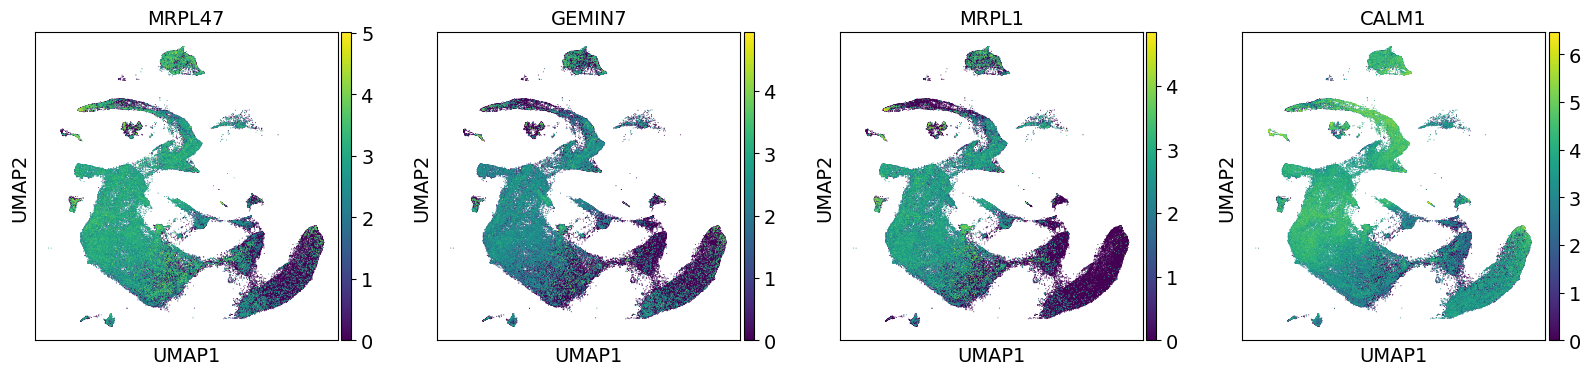

In [8]:
sc.pl.umap(adata, color= wc["names"][1000:1004], size=2 ) # top

## Loop to produce the lists of MegaK_Erys subtypes

In [9]:
Subtypes = adata.obs['anno_lvl_2_final_clean'].unique()
Subtypes

['EARLY_ERY', 'MEMP', 'EARLY_MK', 'MACROPHAGE_ERY', 'MID_ERY', 'VSMC_PERICYTE_III', 'MEP', 'LATE_ERY', 'LATE_MK', 'YS_ERY']
Categories (10, object): ['MEMP', 'MEP', 'EARLY_ERY', 'MID_ERY', ..., 'EARLY_MK', 'LATE_MK', 'VSMC_PERICYTE_III', 'MACROPHAGE_ERY']

In [10]:
for i in range(0,len(Subtypes)):
    print(i, Subtypes[i])

0 EARLY_ERY
1 MEMP
2 EARLY_MK
3 MACROPHAGE_ERY
4 MID_ERY
5 VSMC_PERICYTE_III
6 MEP
7 LATE_ERY
8 LATE_MK
9 YS_ERY


### Marker genes for each Subtype

In [11]:
Markers = [[]]*len(Subtypes)

for i in range(0,len(Subtypes)):
    print(i, Subtypes[i])
    m = sc.get.rank_genes_groups_df(adata, group=Subtypes[i],
                                    key='wilcoxon', pval_cutoff=0.0001,
                                    log2fc_min=1)
    m = m.sort_values("logfoldchanges", ascending=False)
    m.reset_index(drop=True, inplace=True)
    Markers[i] = m

0 EARLY_ERY
1 MEMP
2 EARLY_MK
3 MACROPHAGE_ERY
4 MID_ERY
5 VSMC_PERICYTE_III
6 MEP
7 LATE_ERY
8 LATE_MK
9 YS_ERY


### Show UMAPS

In [12]:
#for i in range(0,len(Subtypes)):
#    ## Top markers
#    print(i, Subtypes[i])
#    sc.pl.umap(adata, color= Markers[i].loc[0:3,'names']) # top

### Get names of 300 top markers (if possible) for each Subtype

In [13]:
#pip install upsetplot
from upsetplot import from_contents
from upsetplot import UpSet

In [14]:
Sets = [[]]*len(Subtypes)
CompleteSets = [[]]*len(Subtypes)

for i in range(0,len(Subtypes)):
    CompleteSets[i] = Markers[i]['names']
    n = len(Markers[i])
    #print(i, Subtypes[i], n)
    if n > 300 :
        #print("yes")
        Sets[i] = Markers[i].loc[0:299,'names']
    else :
        #print("no")
        Sets[i] = Markers[i].loc[0:n-1,'names']

In [15]:
Dict_markers =  {}
CompleteDict_markers =  {}

for i in range(0,len(Subtypes)):
    Dict_markers[Subtypes[i]] = Sets[i]
    CompleteDict_markers[Subtypes[i]] = CompleteSets[i]    

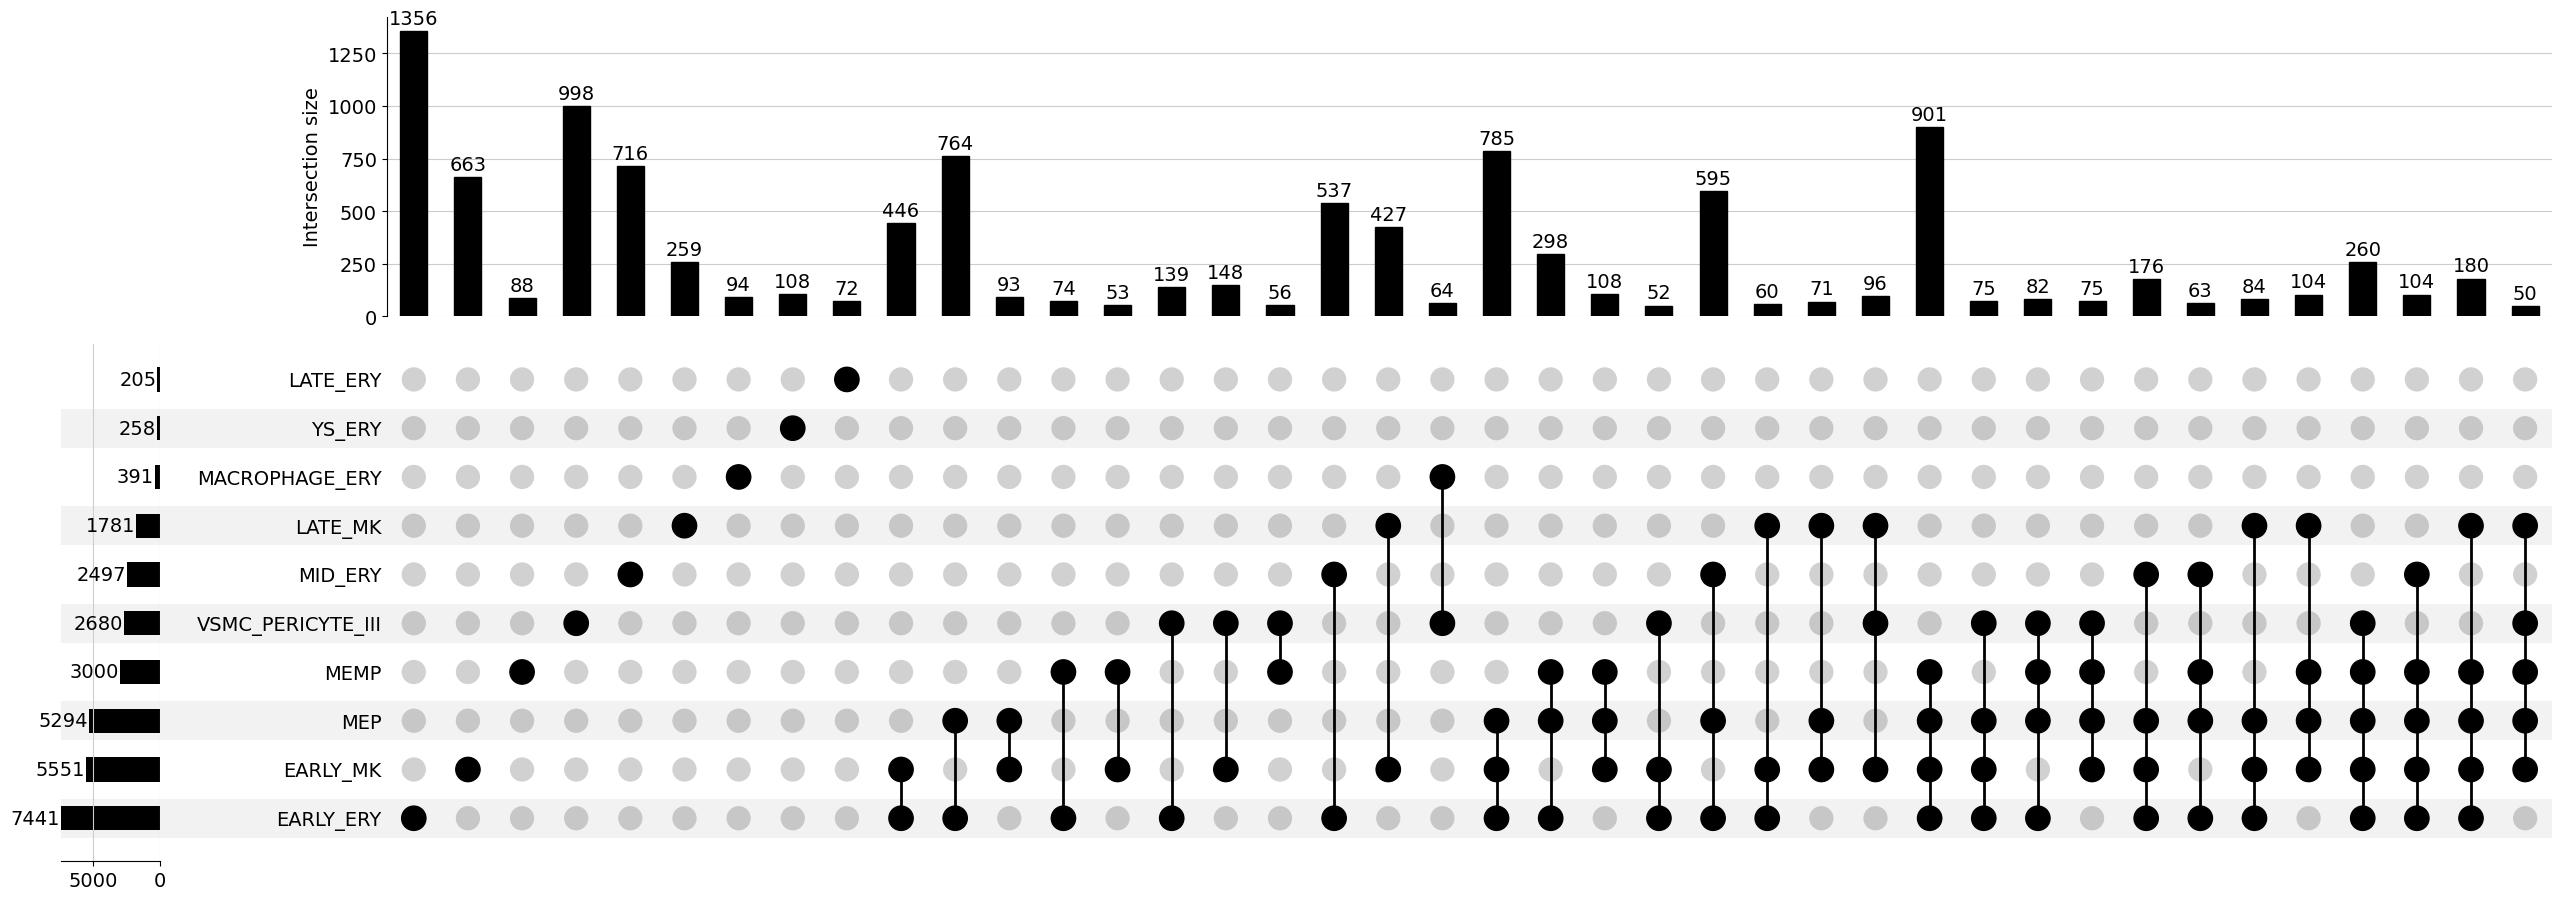

In [16]:
CT_markers = from_contents(CompleteDict_markers)

plt = UpSet(CT_markers, min_subset_size=50, subset_size='count',element_size=50,  show_counts=True).plot()

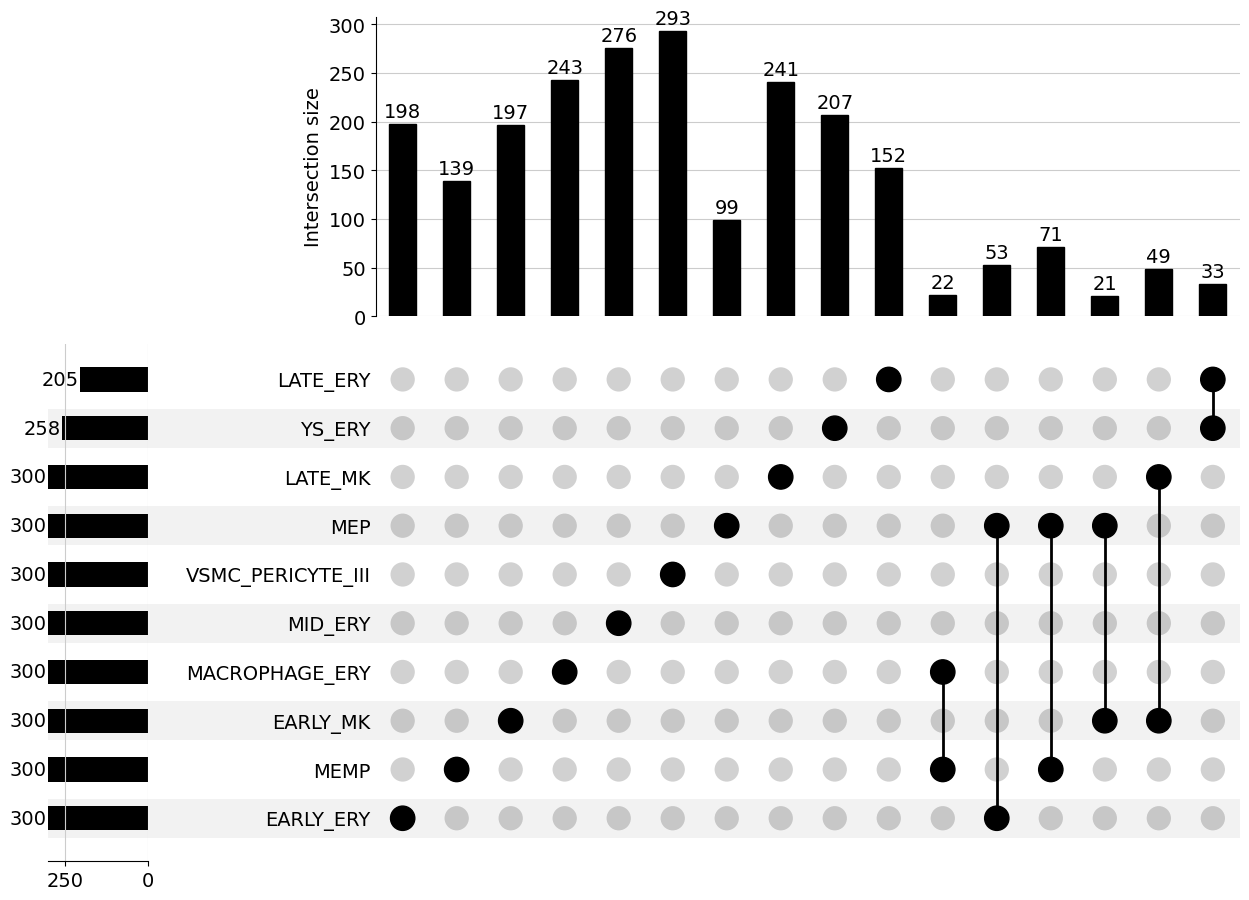

In [17]:
CT_markers = from_contents(Dict_markers)

plt = UpSet(CT_markers, min_subset_size=20, subset_size='count',element_size=50,  show_counts=True).plot()

In [18]:
Dict_markers['LATE_ERY'].loc[0:3]

0       HBB
1    IFIT1B
2      HBG1
3     TMCC2
Name: names, dtype: object

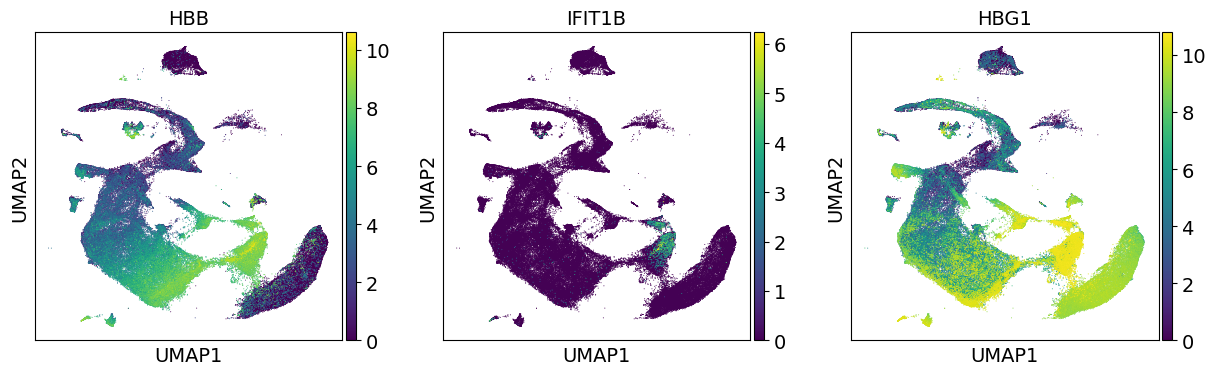

In [19]:
sc.pl.umap(adata, color= ["HBB", "IFIT1B","HBG1"], size= 2  ) # top

In [20]:
#CT_markers.loc[(False,False,False,False,False,False,False,False,True), "id"]


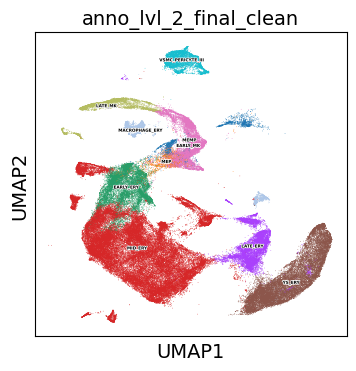

In [21]:
sc.pl.umap(adata, color=["anno_lvl_2_final_clean"],
           legend_loc = 'on data',legend_fontoutline =1,
           save= "MegaK_Ery.png", legend_fontsize= 3 )

In [22]:
# Calling DataFrame constructor after zipping
# both lists, with columns specified
df = pd.DataFrame(list(zip(Sets[0],  Sets[1], Sets[2],
                           Sets[3], Sets[4],  Sets[5],
                           Sets[6],  #Sets[7]
                           Sets[8])),#, Sets[9]
               columns =[Subtypes[0], Subtypes[1], Subtypes[2],
                         Subtypes[3], Subtypes[4], Subtypes[5],
                         Subtypes[6],# Subtypes[7],
                         Subtypes[8]])#, Subtypes[9]

LATE_ERY_df = pd.DataFrame(list(zip(Sets[7])),columns =[Subtypes[7]])
YS_ERY_df   = pd.DataFrame(list(zip(Sets[9])),columns =[Subtypes[9]])

df

,EARLY_ERY,MEMP,EARLY_MK,MACROPHAGE_ERY,MID_ERY,VSMC_PERICYTE_III,MEP,LATE_MK
0,AL662860.1,SPINK2,PLEK,LILRB5,XAGE2,LUM,DHRS9,MAGEA11
1,EPX,AC026369.3,PF4,CD5L,HBG2,FRZB,IL1B,LINC01750
2,HDC,HLF,ITGA2B,SIGLEC1,AHSP,HAND1,AIF1,AC068759.1
3,APOC1,RGL4,GP9,MS4A7,SPRR2F,COL3A1,HBD,PTHLH
4,PRSS57,FLT3,MMRN1,MARCO,GKN2,PITX2,PKM,LINC01754
...,...,...,...,...,...,...,...,...
295,LINC01150,IL18R1,IFITM2,CST3,LRR1,MAGEL2,PODXL2,CACNB1
296,KIF13A,SNX10,CYBA,ZFYVE16,LIG1,ANK3,PGM1,AP000866.2
297,RAC2,IKZF2,LRRK2,LGALS9,SNRPB,GAL3ST4,CALCRL,RAB30
298,XYLT1,PSMB8,AC117498.2,PFKFB3,HIST1H2AI,RASL12,CD164,MEG3


In [23]:
# pip install rpy2
# enables the %%R magic, not necessary if you've already done this
%load_ext rpy2.ipython

In [24]:
%%R -i df -w 5 -h 5 --units in -r 200
# import df from global environment
# make default figure size 5 by 5 inches with 200 dpi resolution
library("EnsDb.Hsapiens.v86")

head(df)

R[write to console]: Loading required package: ensembldb

R[write to console]: Loading required package: BiocGenerics

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


R[write to console]: Loading required package: GenomicRanges

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: S4Vectors

R[write to console]: 
Attaching package: ‘S4Vectors’


R[write to cons

   EARLY_ERY       MEMP EARLY_MK MACROPHAGE_ERY   MID_ERY VSMC_PERICYTE_III
0 AL662860.1     SPINK2     PLEK         LILRB5     XAGE2               LUM
1        EPX AC026369.3      PF4           CD5L      HBG2              FRZB
2        HDC        HLF   ITGA2B        SIGLEC1      AHSP             HAND1
3      APOC1       RGL4      GP9          MS4A7    SPRR2F            COL3A1
4     PRSS57       FLT3    MMRN1          MARCO      GKN2             PITX2
5    FAM178B       HOPX   TMSB4X           C1QB LINC01133            CRABP2
       MEP    LATE_MK
0    DHRS9    MAGEA11
1     IL1B  LINC01750
2     AIF1 AC068759.1
3      HBD      PTHLH
4      PKM  LINC01754
5 SERPINB1     TMEM40


In [25]:
%%R

library(stringr)
dim(df)
genelists <- colnames(df)
path <- "~/Desktop/Github/Immune_Adaptation_Atlas/ENS_genelists_wilcox/MegaK_Ery/"

for (i in genelists)
    {
    goi <- df[,i]
    #print(i)
    f <- str_remove_all(i, "[()]")
    print(f)
    ens_df <- ensembldb::select(EnsDb.Hsapiens.v86, keys= goi, 
                              keytype = "SYMBOL", 
                              columns = c("SYMBOL","GENEID"))
   
    ens_df <- ens_df$GENEID[grepl(pattern = "^ENS", x = ens_df$GENEID)]
    #print(head(ens_df)) 

    write(x = ens_df, file = paste0(path, f ,"_ENSEMBL.txt"),ncolumns = 1)

    }


[1] "EARLY_ERY"
[1] "MEMP"
[1] "EARLY_MK"
[1] "MACROPHAGE_ERY"
[1] "MID_ERY"
[1] "VSMC_PERICYTE_III"
[1] "MEP"
[1] "LATE_MK"


In [26]:
%%R -i LATE_ERY_df
# import df from global environment
head(LATE_ERY_df)

goi <- LATE_ERY_df[,1]
f <- str_remove_all(colnames(LATE_ERY_df)[1], "[()]") 
print(f)
ens_df <- ensembldb::select(EnsDb.Hsapiens.v86, keys= goi, 
                            keytype = "SYMBOL", 
                            columns = c("SYMBOL","GENEID"))
   
ens_df <- ens_df$GENEID[grepl(pattern = "^ENS", x = ens_df$GENEID)]
print(head(ens_df)) 

write(x = ens_df, file = paste0(path, f,"_ENSEMBL.txt"),ncolumns = 1)

[1] "LATE_ERY"
[1] "ENSG00000244734" "ENSG00000204010" "ENSG00000213934" "ENSG00000133069"
[5] "ENSG00000188536" "ENSG00000206172"


In [27]:
%%R -i YS_ERY_df
# import df from global environment
head(YS_ERY_df)

goi <- YS_ERY_df[,1]
f <- str_remove_all(colnames(YS_ERY_df)[1], "[()]") 
print(f)
ens_df <- ensembldb::select(EnsDb.Hsapiens.v86, keys= goi, 
                            keytype = "SYMBOL", 
                            columns = c("SYMBOL","GENEID"))
   
ens_df <- ens_df$GENEID[grepl(pattern = "^ENS", x = ens_df$GENEID)]
print(head(ens_df)) 

write(x = ens_df, file = paste0(path, f,"_ENSEMBL.txt"),ncolumns = 1)

[1] "YS_ERY"
[1] "ENSG00000213931" "ENSG00000130656" "ENSG00000125144" "ENSG00000198417"
[5] "ENSG00000205358" "ENSG00000187193"


## Export full list of marker genes

In [28]:
full_csv_path = '/home/irepan/Desktop/Github/Immune_Adaptation_Atlas/ENS_FULL_genelists_wilcox/MegaK_Ery/full.csv'

(pd.DataFrame.from_dict(data=CompleteDict_markers, orient='index')
   .to_csv(full_csv_path, header=False))

In [29]:
%%R -i full_csv_path
library("EnsDb.Hsapiens.v86")
library(stringr)

path <- "~/Desktop/Github/Immune_Adaptation_Atlas/ENS_FULL_genelists_wilcox/MegaK_Ery/"

mycsv <- read.csv(full_csv_path, row.names = 1,header = F, na.strings = "")

for (i in 1:nrow(mycsv))
{
    genelist <- row.names(mycsv)[i]
    n <- sum(!is.na(mycsv[i,]))
    #print(paste0(n," genes"))
    
    goi <- as.character(mycsv[i,1:n])
    print(goi[1:5])

    f <- str_remove_all(genelist, "[()]")
    print(f)
    ens_df <- ensembldb::select(EnsDb.Hsapiens.v86, keys= goi, 
                              keytype = "SYMBOL", 
                              columns = c("SYMBOL","GENEID"))
   
    ens_df <- ens_df$GENEID[grepl(pattern = "^ENS", x = ens_df$GENEID)]
    #print(head(ens_df)) 

    write(x = ens_df, file = paste0(path, f ,"_FULL_ENSEMBL.txt"),ncolumns = 1)

}


[1] "AL662860.1" "EPX"        "HDC"        "APOC1"      "PRSS57"    
[1] "EARLY_ERY"
[1] "SPINK2"     "AC026369.3" "HLF"        "RGL4"       "FLT3"      
[1] "MEMP"
[1] "PLEK"   "PF4"    "ITGA2B" "GP9"    "MMRN1" 
[1] "EARLY_MK"
[1] "LILRB5"  "CD5L"    "SIGLEC1" "MS4A7"   "MARCO"  
[1] "MACROPHAGE_ERY"
[1] "XAGE2"  "HBG2"   "AHSP"   "SPRR2F" "GKN2"  
[1] "MID_ERY"
[1] "LUM"    "FRZB"   "HAND1"  "COL3A1" "PITX2" 
[1] "VSMC_PERICYTE_III"
[1] "DHRS9" "IL1B"  "AIF1"  "HBD"   "PKM"  
[1] "MEP"
[1] "HBB"    "IFIT1B" "HBG1"   "TMCC2"  "HBA2"  
[1] "LATE_ERY"
[1] "MAGEA11"    "LINC01750"  "AC068759.1" "PTHLH"      "LINC01754" 
[1] "LATE_MK"
[1] "HBE1" "HBZ"  "MT1G" "MT1F" "MT1H"
[1] "YS_ERY"
